# 03 - Una Revisión a la Estadística: La Ecuacuación Más Peligrosa

En su famoso artículo de 2007, Howard Wainer escribe sobre ecuaciones muy peligrosas:

"Algunas ecuaciones son peligrosas si las conoces, y otras son peligrosas si no las conoces. La primera categoría puede representar un peligro porque los secretos dentro de sus límites abren puertas detrás de las cuales yace un peligro terrible. El ganador obvio en esto es la ecuación icónica de Einstein $E = MC^2$, ya que proporciona una medida de la enorme energía oculta dentro de la materia ordinaria.\[...\] En cambio, me interesan las ecuaciones que desencadenan su peligro no cuando las conocemos, sino cuando no las conocemos. Mantenidas a mano, estas ecuaciones nos permiten entender las cosas con claridad, pero su ausencia nos deja peligrosamente ignorantes".

La ecuación de la que habla es la ecuación de Moivre:

$
SE = \dfrac{\sigma}{\sqrt{n}} 
$

donde $SE$ es el error estándar de la media, $\sigma$ es la desviación estándar y $n$ es el tamaño de la muestra. Suena como una pieza de matemáticas que los valientes y verdaderos deberían dominar, así que vamos a hacerlo.

Para ver por qué no conocer esta ecuación es muy peligroso, veamos algunos datos educativos. Recopilé datos sobre puntajes ENEM (puntajes de una escuela secundaria estandarizados en Brasil, similares al SAT en Estados Unidos) de diferentes escuelas durante 3 años. También limpié los datos para mantener solo la información relevante para nosotros. Los datos originales se pueden descargar en el [sitio web del Inep](http://portal.inep.gov.br/web/guest/microdados#).

Si observamos la escuela con el mejor desempeño, algo llama la atención: esas escuelas tienen un número razonablemente pequeño de estudiantes. 

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [17]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Mirando desde otro ángulo, podemos separar solo el 1% de las mejores escuelas y estudiarlas. ¿Cómo son? Tal vez podamos aprender algo de los mejores y replicarlo en otros lugares. Y efectivamente, si observamos el 1% superior de las escuelas, descubrimos que tienen, en promedio, menos estudiantes.

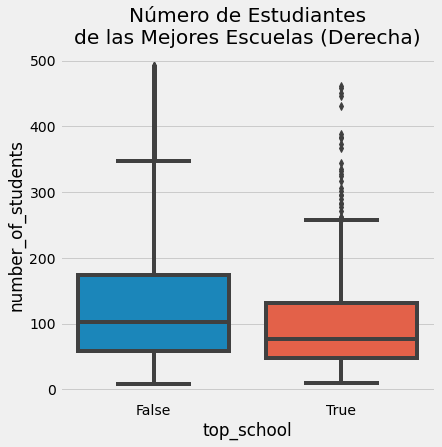

In [18]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Número de Estudiantes\nde las Mejores Escuelas (Derecha)");

Una conclusión natural es que las escuelas pequeñas conducen a un mayor rendimiento académico. Esto tiene un sentido intuitivo ya que creemos que menos estudiantes por maestro le permiten al maestro prestar atención enfocada a cada estudiante. Pero, ¿qué tiene esto que ver con la ecuación de Moivre? ¿Y por qué es peligroso? 

Bueno, se vuelve peligroso una vez que las personas comienzan a tomar decisiones importantes y costosas basadas en esta información. En su artículo, Howard continúa:

"En la década de 1990, se hizo popular defender las reducciones en el tamaño de las escuelas. Numerosas organizaciones filantrópicas y agencias gubernamentales financiaron la división de las escuelas más grandes porque los estudiantes de las escuelas pequeñas están sobrerrepresentados en los grupos con puntajes altos en las pruebas".

Lo que la gente olvidó hacer fue mirar también al 1% inferior de las escuelas. Si hacemos eso, ¡también tienen muy pocos estudiantes!

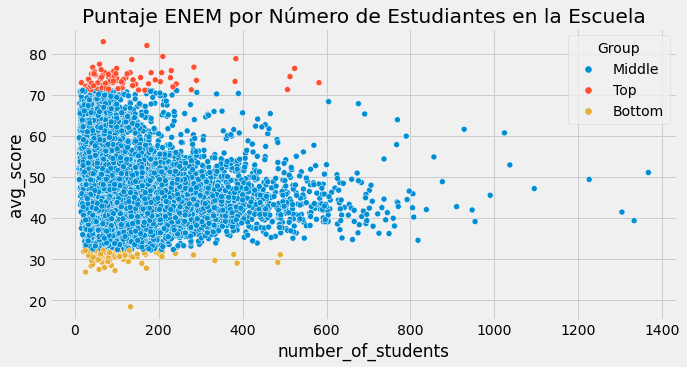

In [19]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("Puntaje ENEM por Número de Estudiantes en la Escuela");

Estamos viendo arriba precisamente lo que se espera según la ecuación de Moivre. A medida que crece el número de estudiantes, la puntuación media se vuelve cada vez más precisa. Las escuelas con muy pocas muestras pueden tener puntajes muy altos y bajos simplemente por casualidad. Esto es menos probable que ocurra en escuelas grandes. La ecuación de Moivre habla de un hecho fundamental sobre la realidad de la información y los registros en forma de datos: siempre es impreciso. La pregunta entonces se convierte en cuán inexacto.

La estadística es la ciencia que se ocupa de estas imprecisiones, para que no nos pillen desprevenidos. Como dice Taleb en su libro, _Fooled by Randomness_:

> La probabilidad no es un mero cálculo de probabilidades en los dados o variantes más complicadas; es la aceptación de la falta de certeza en nuestro conocimiento y el desarrollo de métodos para lidiar con nuestra ignorancia.

Una forma de cuantificar nuestra incertidumbre es la **varianza de nuestras estimaciones**. La varianza nos dice cuánto se desvía la observación de su valor central y más probable. Como indica la ecuación de Moivre, esta incertidumbre se reduce a medida que aumenta la cantidad de datos que observamos. Esto tiene sentido, ¿verdad? Si vemos que muchos estudiantes se desempeñan de manera excelente en una escuela, podemos estar más seguros de que esta es una buena escuela. Sin embargo, si vemos una escuela con solo 10 estudiantes y 8 de ellos se desempeñan bien, debemos desconfiar más. Por casualidad, podría ser que la escuela tuviera algunos estudiantes por encima del promedio.

La hermosa trama triangular que vemos arriba cuenta precisamente esta historia. Nos muestra cómo nuestras estimaciones del rendimiento escolar tienen una gran variación cuando los tamaños de muestra son pequeños. También indica que la varianza se reduce a medida que aumenta el tamaño de la muestra. Esto es cierto para el puntaje promedio en una escuela, pero también es cierto para cualquier estadística resumida que tengamos, incluido el _ATE_ que a menudo queremos estimar.

##  El Error Estándar de Nuestras Estimaciones

Dado que esto es solo una revisión, me tomaré la libertad de ir un poco más rápido ahora. Si no está familiarizado con las distribuciones, la varianza y los errores estándar, sigue leyendo, pero ten en cuenta que es posible que necesite algunos recursos adicionales. Te sugiero que busques en Google cualquier curso del MIT sobre introducción a la Estadística. Suelen ser bastante buenos.

En la sección anterior, estimamos el efecto promedio del tratamiento $E[Y_1-Y_0]$ como la diferencia de las medias entre los tratados y los no tratados $E[Y|T=1]-E[Y|T=0]$ . Descubrimos el $ATE$ para las clases en línea como nuestro ejemplo motivador. También vimos un impacto negativo; Las clases en línea hicieron que los estudiantes se desempeñaran alrededor de 5 puntos peor que los estudiantes con clases presenciales. Ahora, podemos ver si este impacto es estadísticamente significativo.

Para hacerlo, necesitamos estimar el $SE$. Ya tenemos $n$, nuestro tamaño de muestra. Para obtener la estimación de la desviación estándar, podemos hacer lo siguiente

$
\hat{\sigma}^2=\sqrt{\frac{1}{N-1}\sum_{i=0}^N (x-\bar{x})^2}
$

donde $\bar{x}$ es la media de $x$. Afortunadamente para nosotros, la mayoría del software de programación ya implementaron esto. En `pandas`, podemos usar el método [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html).

In [20]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("Desviación Estándar para Clases En Linea:", se(online))
print("Desviación Estándar para Clases Frente-a-Frente:", se(face_to_face))

Desviación Estándar para Clases En Linea: 1.5371593973041635
Desviación Estándar para Clases Frente-a-Frente: 0.8723511456319104


## Intervalos de Confianza

El error estándar de nuestra estimación es una medida de confianza. Necesitamos adentrarnos en aguas estadísticas turbulentas y polémicas para comprender con precisión lo que significa. Para una visión de la _Estadística_, la visión frecuentista, diríamos que nuestros datos no son más que una manifestación de un proceso preciso de generación de datos. Este proceso es abstracto e ideal. Se rige por parámetros verdaderos que son inmutables pero también desconocidos para nosotros. En el contexto de la prueba de los estudiantes, si pudiéramos ejecutar múltiples experimentos y recopilar múltiples conjuntos de datos, todo se parecería al verdadero proceso de generación de datos subyacente, pero no sería exactamente igual. Esto es muy parecido al escrito de Platón sobre las Formas:

> Cada [una de las formas esenciales] se manifiesta en una gran variedad de combinaciones, con acciones, con cosas materiales y entre sí, y cada una parece ser muchas

Supongamos que tenemos una verdadera distribución abstracta de los puntajes de las pruebas de los estudiantes para comprender mejor esto. Esta es una distribución normal con una media real de 74 y una desviación estándar real de 2. A partir de esta distribución, podemos realizar 10000 experimentos. En cada uno, recolectamos 500 muestras. Si los representamos en un histograma, podemos ver que las medias de los experimentos se distribuyen alrededor de la media verdadera. Algunos datos del experimento tendrán una media más baja que la verdadera, y algunos serán más altos.

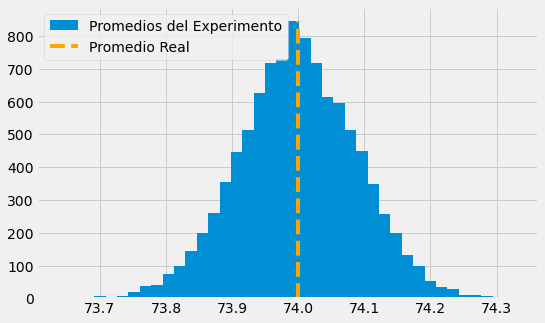

In [21]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Promedios del Experimento")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="Promedio Real", color="orange")
plt.legend();


Nota que aquí estamos hablando de la media de las medias. Entonces, por casualidad, podríamos tener un experimento en el que la media esté un poco por debajo o por encima de la verdadera media. Esto quiere decir que nunca podemos estar seguros de que la media de nuestro experimento coincida con la verdadera media platónica e ideal. Sin embargo, **con el error estándar, podemos crear un intervalo que contenga la verdadera media el 95 % del tiempo**.

En la vida real, no podemos darnos el lujo de simular el mismo experimento con múltiples conjuntos de datos. Muchas veces solo tenemos uno. Pero podemos recurrir a la intuición anterior para construir lo que llamamos **intervalos de confianza**. Los intervalos de confianza vienen con una probabilidad asociada a ellos. El más común es el 95%. Esta probabilidad nos dice cuántos intervalos de confianza hipotéticos construiríamos a partir de diferentes estudios que contienen la media verdadera. Por ejemplo, los intervalos de confianza del 95 % calculados a partir de estudios similares incluirían la media real el 95 % de las veces. 

Para calcular el intervalo de confianza, usamos el **teorema del límite central**. Este teorema establece que **las medias de los experimentos se distribuyen normalmente**. De la teoría _Estadística_, sabemos que el 95% de la masa de una distribución normal está entre 2 desviaciones estándar por encima y por debajo de la media. Técnicamente, 1,96, pero 2 está lo suficientemente cerca. 

![normal_density](./data/img/stats-review/normal_dist.jpeg)

El error estándar de la media sirve como nuestra estimación de la distribución de las medias del experimento. Entonces, si lo multiplicamos por 2 y lo sumamos y lo restamos de la media de uno de nuestros experimentos, construiremos un intervalo de confianza del 95% para la verdadera media.

In [22]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


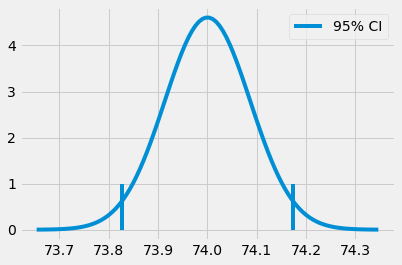

In [23]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

Por supuesto, no necesitamos restringirnos al intervalo de confianza del 95%. Podríamos generar el intervalo del 99% encontrando lo que necesitamos para multiplicar la desviación estándar por lo que el intervalo contiene el 99% de la masa de una distribución normal. 

La función `ppf` en python nos da el inverso de la CDF. En lugar de multiplicar el error estándar por 2 como hicimos para encontrar el IC del 95 %, lo multiplicaremos por 'z', lo que dará como resultado el IC del 99 %. Entonces, `ppf(0.5)` devolverá 0.0, diciendo que el 50% de la masa de la distribución normal estándar está por debajo de 0.0. Del mismo modo, si tapamos el 99,5 %, tendremos el valor `z`, de modo que el 99,5 % de la masa de distribución cae por debajo de este valor. En otras palabras, el 0,05% de la masa cae por encima de este valor.

In [24]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

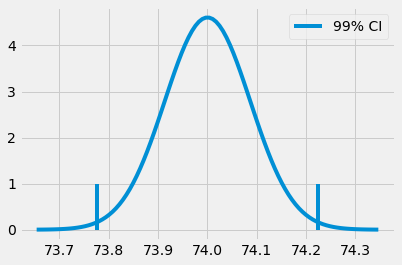

In [25]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

Volviendo a nuestro experimento en el aula, podemos construir el intervalo de confianza para la puntuación media del examen tanto para el grupo de estudiantes en línea como para el presencial.

In [26]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("Intervalo de Confianza del 95% para clases en linea:", ci(online))
print("Intervalo de Confianza del 95% para clases presenciales:", ci(face_to_face))

Intervalo de Confianza del 95% para clases en linea: (70.56094429049804, 76.7095818797147)
Intervalo de Confianza del 95% para clases presenciales: (76.80278229206948, 80.29218687459712)


Podemos ver que el IC (_Intervalo de Confianza_) del 95% de los grupos no se superpone. El extremo inferior del IC para clases presenciales está por encima del extremo superior del IC para clases en línea. Esta es una evidencia de que nuestro resultado no es casual y que la verdadera media de los estudiantes en las clases presenciales es más alta que la verdadera media de los estudiantes en las clases en línea. En otras palabras, existe una disminución causal significativa en el rendimiento académico al pasar de clases presenciales a clases en línea.

En resumen, los intervalos de confianza son una forma de generar incertidumbre en torno a nuestras estimaciones. Cuanto menor sea el tamaño de la muestra, mayor será el error estándar y más amplio el intervalo de confianza. Dado que son muy fáciles de calcular, la falta de intervalos de confianza indica malas intenciones o simplemente falta de conocimiento, lo cual es igualmente preocupante. Finalmente, siempre debe desconfiar de las mediciones sin ninguna métrica de incertidumbre. 

![img](data/img/stats-review/ci_xkcd.png)

Una última palabra de precaución aquí. Los intervalos de confianza son más difíciles de interpretar a primera vista. Por ejemplo, **no debería** decir que este intervalo de confianza del 95 % en particular contiene la verdadera media de la población con una probabilidad del 95 %. En la _Estadística_ frecuentista que utiliza intervalos de confianza, la media poblacional se considera una verdadera constante poblacional. Entonces, está o no está en nuestro intervalo de confianza particular. En otras palabras, nuestro intervalo de confianza específico contiene o no contiene la verdadera media. Si lo hace, la probabilidad de contenerlo sería del 100 %, no del 95 %. Si no es así, la probabilidad sería del 0%. En cambio, en los intervalos de confianza, el 95 % se refiere a la frecuencia con la que dichos intervalos de confianza, calculados en muchos estudios, contienen la media verdadera. El 95 % es nuestra confianza en el algoritmo utilizado para calcular el IC del 95 %, no en el intervalo particular en sí.

Ahora, habiendo dicho eso, como economista (personas estadísticas, por favor miren hacia otro lado ahora), creo que este purismo no es muy útil. En la práctica, verá personas que dicen que el intervalo de confianza particular contiene la media verdadera el 95% de las veces. Aunque erróneo, esto no es muy dañino, ya que aún coloca un grado preciso de incertidumbre en nuestras estimaciones. Además, si cambiamos a la _Estadística Bayesiana_ y usamos intervalos probables en lugar de intervalos de confianza, podríamos decir que el intervalo contiene la media de distribución el 95% del tiempo. Además, por lo que he visto en la práctica, con tamaños de muestra decentes, los intervalos de probabilidad bayesianos son más similares a los intervalos de confianza que a los bayesianos, y a los frecuentistas les gustaría admitir. Entonces, si mi palabra cuenta para algo, siéntete libre de decir lo que quieras sobre tu intervalo de confianza. No me importa si dices que contienen la verdadera media el 95% de las veces. Por favor, nunca olvides colocarlos alrededor de sus estimaciones; de lo contrario, te verás tonto. 


## Prueba de Hipótesis

Otra forma de incorporar la incertidumbre es establecer una prueba de hipótesis: ¿la diferencia de medias es estadísticamente diferente de cero (o de cualquier otro valor)? Recordemos que la suma o diferencia de 2 distribuciones normales independientes también es distribución normal. La media resultante será la suma o diferencia entre las dos distribuciones, mientras que la varianza será siempre la suma de la varianza:

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

Si no lo recuerdas, está bien. Siempre podemos usar código y datos simulados para verificar:

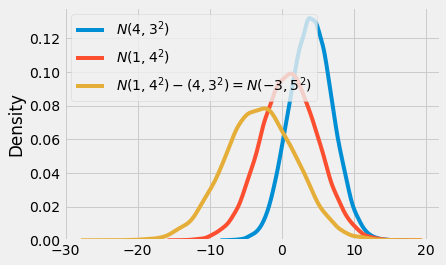

In [27]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

Si tomamos la distribución de las medias de nuestros 2 grupos y restamos uno del otro, tendremos una tercera distribución. La media de esta distribución final será la diferencia de las medias, y la desviación estándar de esta distribución será la raíz cuadrada de la suma de las desviaciones estándar.

$
\mu_{diff} = \mu_1 - \mu_2
$

$
SE_{diff} = \sqrt{SE_1 + SE_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

Volvamos a nuestro ejemplo del salón de clases. Construiremos esta distribución de la diferencia. Por supuesto, una vez que lo tenemos, construir el IC del 95 % es sencillo.

In [28]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363357, -1.4480327880904964)


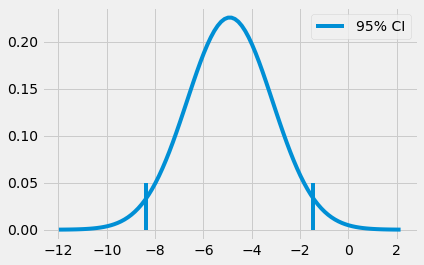

In [29]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

Con esto en la mano, podemos decir que estamos 95% seguros de que la verdadera diferencia entre los grupos en línea y presencial se encuentra entre -8.37 y -1.44. También podemos construir una **estadística z** dividiendo la diferencia en la media por el \$SE\\$ de las diferencias.

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

Donde $H_0$ es el valor contra el que queremos probar nuestra diferencia.

El estadístico `z` es una medida de cuán extrema es la diferencia observada. Usaremos la contradicción para probar nuestra hipótesis de que la diferencia en las medias es estadísticamente diferente de cero. Supondremos que lo contrario es cierto; supondremos que la diferencia es cero. Esto se llama hipótesis nula, o $H_0$. Entonces, nos preguntaremos, "¿es probable que observemos tal diferencia si la verdadera diferencia fuera cero?" Podemos traducir esta pregunta para verificar qué tan lejos de cero está nuestro estadístico `z` en términos matemáticos. 

Bajo $H_0$, el estadístico `z` sigue una distribución normal estándar. Entonces, si la diferencia es realmente cero, veríamos el estadístico `z` dentro de 2 desviaciones estándar de la media el 95%. La consecuencia directa es que si `z` cae por encima o por debajo de 2 desviaciones estándar, podemos rechazar la hipótesis nula con un 95% de confianza.

Veamos cómo se ve esto en nuestro ejemplo del salón de clases.

In [30]:
z = diff_mu / diff_se
print(z)

-2.7792810791031064


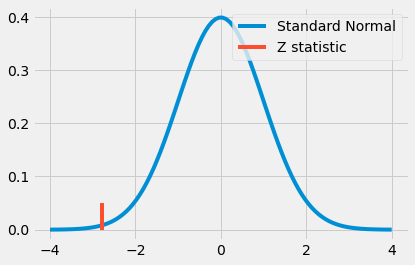

In [31]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

Esto parece un valor bastante extremo. De hecho, está por encima de 2, lo que significa que hay menos del 5% de posibilidades de que veamos un valor tan extremo si no hubiera diferencias en los grupos. Esto nos lleva de nuevo a concluir que el cambio de clases presenciales a online provoca una caída estadísticamente significativa en el rendimiento académico.

Una última cosa interesante sobre las pruebas de hipótesis es que es menos conservadora que verificar si el IC del 95% del grupo tratado y no tratado se superpone. En otras palabras, si los intervalos de confianza en los dos grupos se superponen, aún puede darse el caso de que el resultado sea estadísticamente significativo. Por ejemplo, supongamos que el grupo presencial tiene una puntuación media de 80 con un error estándar de 4, y el grupo online tiene una puntuación media de 71 con un error estándar de 2. 

In [32]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% IC:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% IC:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% IC:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% IC: (67.08, 74.92)
Test 95% IC: (72.16, 87.84)
Diff 95% IC: (0.23461352820082482, 17.765386471799175)


Si construimos los intervalos de confianza para estos grupos, se superponen. El límite superior para el IC del 95 % del grupo en línea es 74,92 y el límite inferior para el grupo presencial es 72,16. Sin embargo, una vez que calculamos el intervalo de confianza del 95 % para la diferencia entre los grupos, podemos ver que no contiene cero. Aunque los intervalos de confianza individuales se superponen, la diferencia aún puede ser estadísticamente diferente de cero.

## Valores-P

Anteriormente, dije que hay menos del 5% de posibilidades de que observemos un valor tan extremo si la diferencia entre los grupos en línea y los presenciales fuera realmente cero. Pero, ¿podemos estimar con precisión cuál es esa probabilidad? ¿Cuán probable es que observemos un valor tan extremo? ¡Presentamos los valores p!

Al igual que con los intervalos de confianza (y la mayoría de la _Estadística_ frecuentista, de hecho), la verdadera definición de los valores p puede ser muy confusa. Entonces, para no correr ningún riesgo, copio la definición de Wikipedia: "el valor p es la probabilidad de obtener resultados de prueba al menos tan extremos como los resultados realmente observados durante la prueba, asumiendo que la hipótesis nula es correcta".

Para decirlo de manera más clara, el valor p es la probabilidad de ver dichos datos, dado que la hipótesis nula es verdadera. Mide cuán improbable es que esté viendo una medición si la hipótesis nula es verdadera. Naturalmente, esto a menudo se confunde con la probabilidad de que la hipótesis nula sea cierta. Tenga en cuenta la diferencia aquí. El valor p NO es $P(H_0|datos)$, sino $P(datos|H_0)$.

Pero no dejes que esta complejidad te engañe. En términos prácticos, son bastante fáciles de usar.

![p_value](./data/img/stats-review/p_value.png)

Para obtener el valor p, necesitamos calcular el área bajo la distribución normal estándar antes o después del estadístico `z`. Afortunadamente, tenemos una computadora que hace este cálculo por nosotros. Simplemente podemos conectar el estadístico `z` en la CDF de la distribución normal estándar.

In [33]:
print("Valor-p:", stats.norm.cdf(z))

Valor-p: 0.0027239680835564706


Observa cómo el valor p es interesante porque nos evita tener que especificar un nivel de confianza, como 95% o 99%. Pero, si deseamos reportar uno, a partir del valor p, sabemos con precisión en qué nivel de confianza pasará o fallará nuestra prueba. Por ejemplo, con un valor p de 0.0027, vemos que tenemos significación hasta el nivel de 0,2 %. Entonces, mientras que el IC del 95 % y el IC del 99 % para la diferencia no contendrán cero, el IC del 99,9 % sí lo hará. Esto significa que solo hay un 0,2 % de probabilidad de observar este estadístico `z` extremo si la diferencia fuera cero.

In [37]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% IC:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% IC:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% IC:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% IC: (-8.37634655308288, -1.4480964433709733)
99% IC: (-9.464853535264012, -0.3595894611898425)
99.9% IC: (-10.72804065824553, 0.9035976617916743)


## Ideas Clave

Hemos visto lo importante que es conocer la ecuación de Moivre y la usamos para otorgar cierto grado de certeza a nuestras estimaciones. Es decir, descubrimos que las clases en línea causan una disminución en el rendimiento académico en comparación con las clases presenciales. También vimos que este era un resultado estadísticamente significativo. Lo hicimos comparando los intervalos de confianza de las medias de los 2 grupos, observando el intervalo de confianza para la diferencia, haciendo una prueba de hipótesis y observando el valor p. Resumamos todo en una sola función que haga una comparación de prueba A/B como la que hicimos arriba.

In [38]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% IC: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% IC: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% IC: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% IC: 73.63526308510637 +- 3.0127770572134565
Control 95.0% IC: 78.5474845833333 +- 1.7097768273108
Test-Control 95.0% IC: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.7792810791031064
P-Value 0.0027239680835564706


Dado que nuestra función es lo suficientemente genérica, podemos probar otras hipótesis nulas. Por ejemplo, ¿podemos intentar rechazar que la diferencia entre el rendimiento en clase en línea y presencial es -1? Con los resultados que obtenemos, podemos decir con un 95 % de confianza que la diferencia es más significativa que -1. Pero no podemos decirlo con un 99% de confianza:

In [39]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% IC: 73.63526308510637 +- 3.0127770572134565
Control 95.0% IC: 78.5474845833333 +- 1.7097768273108
Test-Control 95.0% IC: -4.912221498226927 +- 3.4641250548559537
Z Statistic -2.2134920404560723
P-Value 0.013431870694630667


## Referencias

Me gusta pensar en este libro como un tributo a Joshua Angrist, Alberto Abadie y Christopher Walters por su increíble clase de Econometría. La mayoría de las ideas aquí están tomadas de sus clases en la Asociación Económica Americana. Verlos es lo que me mantiene cuerdo durante este difícil año de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

También me gustaría hacer referencia a los increíbles libros de Angrist. Me han demostrado que la Econometría, o 'Metria como la llaman, no solo es extremadamente útil sino también profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Mi referencia final es el libro de Miguel Hernan y Jamie Robins. Ha sido mi compañero de confianza en las preguntas causales más espinosas que tuve que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

La analogía de la cerveza fue tomada de [Stock Series](https://jlcollinsnh.com/2012/04/15/stocks-part-1-theres-a-major-market-crash-coming-and-dr-lo-cant-save-you/), por JL Colins. Esta es una lectura obligada para todos aquellos que quieran aprender a invertir su dinero de manera productiva.

![img](./data/img/poetry.png)

## Contribute

_Inferencia Causal para los Valientes y Verdaderos_ es un material de código abierto sobre Inferencia Causal, la Estadística de la Ciencia. Utiliza solo software libre, basado en Python. Su objetivo es ser accesible monetaria e intelectualmente.
Si encuentras este libro valioso y quieres apoyarlo, por favor visita [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si no estás listo para contribuir financieramente, también puedes ayudar corrigiendo errores tipográficos, sugiriendo ediciones o dando tu opinión sobre pasajes que no entendiste. Sólo tienes que ir al repositorio del libro y [abrir un _issue_](https://github.com/matheusfacure/python-causality-handbook/issues). Finalmente, si te gustó este contenido, compártelo con otras personas a quienes les pueda resultar útil y dale una [estrella en GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).